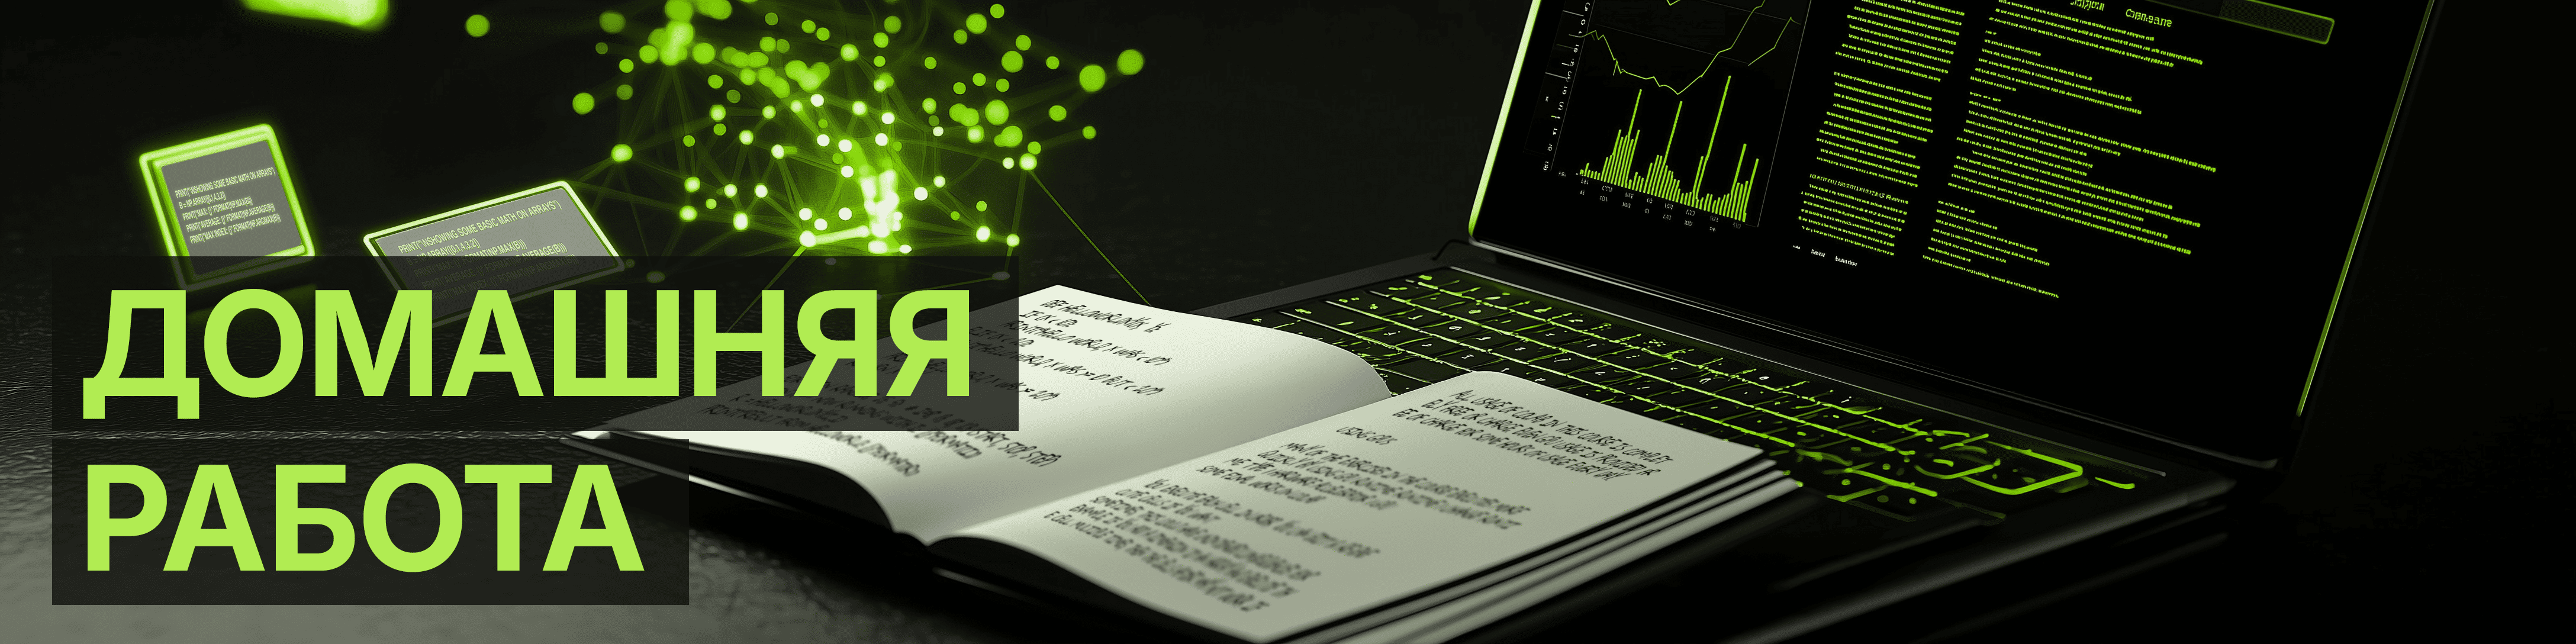

**Навигация по уроку**
1. [Трансформеры](https://colab.research.google.com/drive/1nVnLesLUsqaO3rQP44cfMumoB7m9DDUl)
2. [Португальско-английский переводчик на трансформере](https://colab.research.google.com/drive/1n11KroRJHEWHNRAXJFnCv7XZyLJWmf_b)
3. Домашняя работа

В домашней работе вам необходимо выполнить одно из трёх заданий на выбор:

**Задание 1. На 3 балла:**

Создайте переводчик с одного языка на другой, отличные от тех, что использовались в уроке. Сравните результаты переводов для 4-х, 6-и и 8-и голов (`num_heads`), при одинаковых прочих параметрах. Сделайте выводы письменно в колабе.

**Задание 2. На 4 балла:**

Постройте трансформер для задачи `question answering`. Трансформер должен работать по принципу чат-бота: принимать на вход вопрос, и генерировать ответ на этот вопрос. В качестве датасета используйте `web_questions` из tensorflow_datasets.

Меняя гиперпараметры, добейтесь адекватного качества ответов.

**Задание 3. На 5 баллов:**

Постройте трансформер для задачи `question answering`. Трансформер должен работать по принципу чат-бота: принимать на вход вопрос, и генерировать ответ на этот вопрос.

В качестве датасета необходимо использовать русско-язычный диалог от Денчика с HuggingFace:

```python
dataset = load_dataset('Den4ikAI/russian_dialogues', split='train', )
```

Меняя гиперпараметры, добейтесь адекватного качества ответов.

На 5 баллов задание выполняется самостоятельно без помощи куратора!

In [ ]:
# Логирование для отладки
import logging

# Замеры времени выполнения
import time

# Линейная алгебра
import numpy as np

# Вывод графиков
import matplotlib.pyplot as plt

# Фреймворк Tensorflow
import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text as text
# Регулярные выражения
import re

# Файловая система
import pathlib

# Токенизатор
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

# Отключим мешаюшие предупреждения
import warnings
warnings.filterwarnings("ignore")

# Загрузим и посмотрим датасет

In [ ]:
from datasets import load_dataset

dataset = load_dataset('Den4ikAI/russian_dialogues', split='train', )

README.md:   0%|          | 0.00/951 [00:00<?, ?B/s]

dataset.jsonl:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2477321 [00:00<?, ? examples/s]

In [ ]:
dataset[:2]

{'question': ['как дела?', 'вы кефир пачему не кушаете, не любите?'],
 'answer': ['там хорошо', 'я ряженку лучше люблю.'],
 'relevance': [0, 1]}

In [ ]:
dataset['relevance'].count(1)

1382615

In [ ]:
filtered_0 = dataset.filter(lambda x: x['relevance'] == 0)
count_0 = len(filtered_0)
filtered_1 = dataset.filter(lambda x: x['relevance'] == 1)
count_1 = len(filtered_1)

print('relevance 0: ', count_0)
print('relevance 1: ', count_1)

Filter:   0%|          | 0/2477321 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2477321 [00:00<?, ? examples/s]

relevance 0:  1094706
relevance 1:  1382615


In [ ]:
filtered_1[:10]

{'question': ['вы кефир пачему не кушаете, не любите?',
  'если в расходную накладную забить дури и выкурить, то получится приходный документ?',
  'давай не будем об этом',
  'препарат для лечения сильно понижает давление. что порекомендуете?',
  'мужчина, если ты занюхиваешь волосами соседки, то какой аромат предпочитаешь?',
  'можете ли вы с ходу отличить японских фигуристов от китайских без представления?',
  'как стать наемником?',
  'слышала, что есть крем от шрамов. кто знает, скажите пожалуйста название. и поможет ли он от шрамов которым лет. дцать?',
  'ребята подскажите можно ли с современной китайской альфы, дельты и прочих мопедов поставить габариты на мотоцикл минск?',
  'да , ладно? отлично'],
 'answer': ['я ряженку лучше люблю.',
  'особенно когда придет комиссия проверять документацию',
  'давай поговорим о чем-нибудь другом',
  'чтоб не сильно? или что? препарат принимай и кофе пей',
  'предпочитаю соседкиными пирогами закусывать. -',
  'японцы в целом куда симпатичнее 

In [ ]:
filtered_0[:10]

{'question': ['как дела?',
  'покажись в шапке',
  'я тоже, чуть бессонница бывает, зато утром сплю до  а потом ленюсь весь день',
  'подскажите сайт игр. где можно скачать хорошие игры и без всяких файлообмеников, чтоб скачивать прямо с сайта',
  'что делать если у котенка не отпадает пупок?',
  'как быть если полнота не позволяет быть легкой и стремительной?',
  'и у тебя месячные?',
  'villmont тебя курицы заклевали?',
  'а что вы делаете во время оргазма?',
  'что делать, если мол. человек соврал про свой возраст?'],
 'answer': ['там хорошо',
  'ды щаз приветик',
  'ну тебе по  другому сейчас и не надо. особенно в последние месяцы, я как вспомню',
  'да практически ниоткуда. есть много перепланировок на сайте журнала идеи вашего дома.',
  'каждый человек по своему целитель. отличаемся между собой только багажом знаний и опытом.',
  'классные они у каждого свои. вы бы хоть с жанром определились?',
  'ты точно хочешь это знать?',
  'вы че тут стдрочите?',
  'от наличия самого организ

In [ ]:
none_count = sum(1 for ans in dataset['answer'] if ans is None)
print(f"Количество None в answer: {none_count}")

Количество None в answer: 792


In [ ]:
none_count = sum(1 for q in dataset['question'] if q is None)
print(f"Количество None в question: {none_count}")

Количество None в question: 454


Уберем пустые ответы

In [ ]:
dataset = dataset.filter(lambda x: x['answer'] and x['question'] is not None)

Filter:   0%|          | 0/2477321 [00:00<?, ? examples/s]

# Готовим токенизатор

In [ ]:
# Токенизатор
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

# Регулярные выражения
import re
import pathlib
import tensorflow as tf
import numpy as np

In [ ]:
VOCAB_SIZE = 12000
# Параметры токенизатора (lower_case - приводим к нижнему регистру)
bert_tokenizer_params=dict(lower_case=True)

# Определяем токены, с которыми работает токенизатор
# [START] - начало строки
# [END]   - конец строки
# [UNK]   - неизвестное слово
# [PAD]   - используется для выравнивания длин всех предложений
# [REL], [IRR] - токены релевантности ответов

reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]", "[RELEVANT]", "[IRRELEVANT]"]

bert_vocab_args = dict(
    # Желаемый размер словаря
    vocab_size = VOCAB_SIZE,
    # Токены включаемые в словарь
    reserved_tokens=reserved_tokens,
    # Аргументы для `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Аргументы для `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={}, # не используем, но определяем чтобы не было ошибок
)

In [ ]:
def combine_text(data):
    return {"text": data["question"] + " " + data["answer"]}

combined_dataset = dataset.map(combine_text)

Map:   0%|          | 0/2476083 [00:00<?, ? examples/s]

In [ ]:
combined_dataset[:2]

{'question': ['как дела?', 'вы кефир пачему не кушаете, не любите?'],
 'answer': ['там хорошо', 'я ряженку лучше люблю.'],
 'relevance': [0, 1],
 'text': ['как дела? там хорошо',
  'вы кефир пачему не кушаете, не любите? я ряженку лучше люблю.']}

## обучаем токенизатор

In [ ]:
# Создаем словарь
train_texts = combined_dataset.select_columns(["text"])

# Функция для извлечения текста из словаря
def extract_text(example):
    return example["text"]

train_texts_tf = (
    train_texts.to_tf_dataset()
    .map(extract_text, num_parallel_calls=tf.data.AUTOTUNE)  # Извлекаем только текст (теперь элементы — строки)
    .batch(10000)       # Батчим
    .prefetch(2)        # Prefetch для скорости
)

vocab = bert_vocab.bert_vocab_from_dataset(
    train_texts_tf,
    **bert_vocab_args
)

In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
# Сохраняем словарь
write_vocab_file('ru_vocab.txt', vocab)

In [ ]:
!wget https://storage.yandexcloud.net/quiz.pic/ru_vocab.txt

--2025-09-11 14:55:18--  https://storage.yandexcloud.net/quiz.pic/ru_vocab.txt
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161743 (158K) [text/plain]
Saving to: ‘ru_vocab.txt’

ru_vocab.txt        100%[===================>] 157.95K   184KB/s    in 0.9s    

2025-09-11 14:55:20 (184 KB/s) - ‘ru_vocab.txt’ saved [161743/161743]



In [ ]:
from tensorflow_text import BertTokenizer
import tensorflow_text as text
ru_tokenizer = text.BertTokenizer('ru_vocab.txt', **bert_tokenizer_params)

In [ ]:
test_examples = dataset.shuffle().select(range(5))
test_texts = test_examples['answer']

In [ ]:
test_texts

Column(['эх. разбередила старую рану. был уже джаз-бэнд. меткие шмайссеры. все в прошлом.', 'этого не может быть', 'думаете в тюрьмах только всякое говно без навыков?', 'в данный момент-тишину, после тяжелого дня.', 'потому что тогда ни одного министра и ни одного депутата не останется.'])

Отберем строки для примера:
не, астрал фигня. вообще не очень. как и оно
до фига чего говорят, многое я пропускаю мимо ушей
терпкий, сексуальный, на меня он действует как афродизиак. я не о парфюме
Токенизируем отобранные строки:
[70, 7, 9568, 3241, 9, 150, 70, 127, 9, 72, 47, 310]
[158, 5897, 145, 337, 7, 1180, 69, 200, 7209, 3196, 5712]
[345, 269, 3073, 94, 7, 6484, 7, 73, 97, 111, 3051, 72, 39, 1148, 3639, 4949, 10775, 205, 9, 69, 70, 52, 10792, 88]
Проверим обратное преобразование:
не , астрал фигня . вообще не очень . как и оно
до фига чего говорят , многое я пропускаю мимо ушеи
терпкии , сексуальныи , на меня он деиствует как афродизиак . я не о парфюме


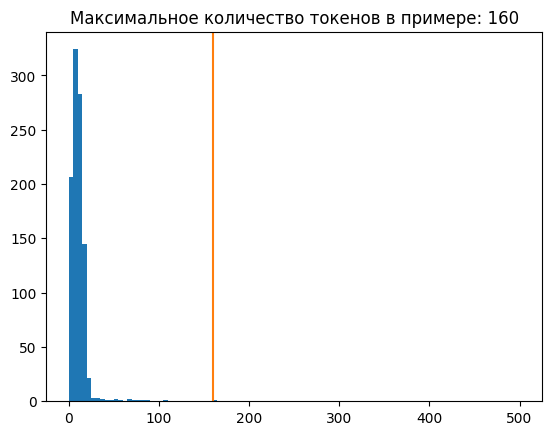

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def text_generator():
    for text in test_texts:
        yield text

train_examples = tf.data.Dataset.from_generator(text_generator, output_types=tf.string).batch(3).take(1)

print('Отберем строки для примера:')
for batch in train_examples:
    for ex in batch:
        print(ex.numpy().decode('utf-8'))  # Декодируем bytes в строку

# Токенизируем примеры
token_batch = ru_tokenizer.tokenize(batch)  # batch — это tf.Tensor с текстами

# Объединяем оси (для word-piece)
token_batch = token_batch.merge_dims(-2, -1)

print('Токенизируем отобранные строки:')
for ex in token_batch.to_list():
    print(ex)

# Обратное преобразование (detokenize)
words = ru_tokenizer.detokenize(token_batch)
print('Проверим обратное преобразование:')
joined = tf.strings.reduce_join(words, separator=' ', axis=-1)
# Декодируем для вывода
for line in joined.numpy():
    print(line.decode('utf-8'))

# Гистограмма длин токенов (на большем батче для статистики)
lengths = []
for batch in tf.data.Dataset.from_generator(text_generator, output_types=tf.string).batch(1024):
    tokens = ru_tokenizer.tokenize(batch)
    lengths.append(tokens.row_lengths())

all_lengths = np.concatenate(lengths)
plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Максимальное количество токенов в примере: {max_length}')
plt.show()

Зададим максимальный размер фраз

In [ ]:
MAX_TOKENS=128

Функции добавления токенов в текст

In [ ]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

In [ ]:
def cleanup_text(reserved_tokens, token_txt):
  # Удаление токенов, кроме "[UNK]".
  # Поиск зарезервированных токенов кроме [UNK]
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  # "Плохие" токены для регулярки объединяем знаком ИЛИ (|)
  bad_token_re = "|".join(bad_tokens)

  # Ищем в строке регулярку
  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  # Отсеиваем из исходной строки все найденные включения "плохих" токенов
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Сцепление строк.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

# Проверяем работу

In [ ]:
# Создаем тестовый набор токенизированных данных (в виде RaggedTensor)
test_tokens = ru_tokenizer.tokenize(test_texts)
test_tokens = test_tokens.merge_dims(-2, -1)

# Применяем add_start_end
tokens_with_start_end = add_start_end(test_tokens)

# Проверяем результат
print("До add_start_end:")
for i, tokens in enumerate(test_tokens.to_list()):
    print(f"Пример {i}: {tokens}")

print("\nПосле add_start_end:")
for i, tokens in enumerate(tokens_with_start_end.to_list()):
    print(f"Пример {i}: {tokens}")

    # Создаем тензор с размерностью [1, sequence_length]
    tokens_tensor = tf.constant([tokens])

    words = ru_tokenizer.detokenize(tokens_tensor)
    print('Проверим обратное преобразование:')
    # Объединение полученного тензора в текст, объединяем пробелами
    joined_text = tf.strings.reduce_join(words, separator=' ', axis=-1)
    raw_text = joined_text.numpy()[0].decode('utf-8')
    print(raw_text)
    print()

    # Применяем cleanup_text к детокенизированному тексту
    cleaned_text = cleanup_text(reserved_tokens, words)

    # Проверяем тип и форму cleaned_text
    print(f"Тип cleaned_text: {type(cleaned_text)}")
    print(f"Форма cleaned_text: {cleaned_text.shape}")

    # Если cleaned_text уже является строкой, просто выводим ее
    if hasattr(cleaned_text, 'numpy'):
        cleaned_result = cleaned_text.numpy()[0].decode('utf-8')
    else:
        # Если это уже строка, просто используем ее
        cleaned_result = str(cleaned_text)

    print('После очистки:')
    print(cleaned_result)
    print()

    # Сравним исходный текст с очищенным
    original_text = test_texts[i]  # Исходный текст из датасета
    print(f'Исходный текст: "{original_text}"')
    print(f'После обработки: "{cleaned_result}"')
    print('---')

# Проверка START/END токенов
for i in range(tokens_with_start_end.shape[0]):
    # Получаем первый токен для каждой последовательности
    first_token = tokens_with_start_end[i][0].numpy()
    # Получаем последний токен для каждой последовательности
    last_token = tokens_with_start_end[i][-1].numpy()

    print(f"Пример {i}: первый токен = {first_token}, последний токен = {last_token}")
    assert first_token == START.numpy()
    assert last_token == END.numpy()

До add_start_end:
Пример 0: [2012, 9, 199, 10102, 9641, 300, 6756, 54, 10551, 9, 235, 114, 43, 1739, 441, 8, 40, 1613, 6600, 9, 50, 7444, 88, 1179, 2063, 10086, 128, 9, 79, 41, 2360, 9]
Пример 1: [215, 70, 109, 117]
Пример 2: [223, 41, 56, 11946, 219, 9705, 98, 4547, 4274, 130, 73, 885, 559, 12]
Пример 3: [41, 1779, 723, 8, 5042, 7, 177, 1155, 197, 773, 9]
Пример 4: [153, 71, 185, 186, 718, 5279, 5449, 47, 186, 718, 10265, 2872, 9667, 95, 70, 1626, 9]

После add_start_end:
Пример 0: [2, 2012, 9, 199, 10102, 9641, 300, 6756, 54, 10551, 9, 235, 114, 43, 1739, 441, 8, 40, 1613, 6600, 9, 50, 7444, 88, 1179, 2063, 10086, 128, 9, 79, 41, 2360, 9, 3]
Проверим обратное преобразование:
[START] эх . разбередила старую рану . был уже джаз - бэнд . меткие шмаиссеры . все в прошлом . [END]

Тип cleaned_text: <class 'tensorflow.python.framework.ops.EagerTensor'>
Форма cleaned_text: (1,)
После очистки:
эх . разбередила старую рану . был уже джаз - бэнд . меткие шмаиссеры . все в прошлом .

Исходный т

## Класс токенизатора

In [ ]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    # Определяем токенизатор
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    # Зарезервированные токены
    self._reserved_tokens = reserved_tokens
    # Путь к файлу словаря
    self._vocab_path = tf.saved_model.Asset(vocab_path)
    # Читаем из файла словарь и делим по строкам
    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    # Для экспорта класса необходимо создать так называемые сигнатуры,
    # чтобы tensorflow понимал с какими данными он работает

    # Сигнатура для tokenize (работает с пакетами строк).
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Сигнатура для `detokenize` и `lookup`
    # Могут работать как с `Tensors`, так и `RaggedTensors`
    # с тензорами формы [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # Методы `get_*` не имеют аргументов
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

    # После определения сигнатур можно определить и сами методы класса

  @tf.function(reduce_retracing=True)
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Объединяем оси `word` и `word-piece` (как в примере выше)
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function(reduce_retracing=True)
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words) # очищаем перед выводом

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids) # возвращаем явное соответствие словаря токенам

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0] # определяем длину словаря по нулевому индексу формы

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path # получение пути к файлу словаря

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens) # получение списка зарезервированных токенов


In [ ]:
custom_tokenizer = CustomTokenizer(
    reserved_tokens=reserved_tokens,
    vocab_path='ru_vocab.txt'
)

## Проверяем

In [ ]:
test_texts_tensor = tf.constant(test_texts[:])

In [ ]:
tokenized = custom_tokenizer.tokenize(test_texts_tensor)
print("Токенизированный результат:")
print(tokenized.to_list())

Токенизированный результат:
[[2, 1157, 3], [2, 434, 81, 9, 86, 70, 478, 7, 96, 261, 503, 1869, 9, 3], [2, 611, 102, 302, 643, 2102, 1944, 102, 8, 628, 2098, 143, 3], [2, 71, 105, 75, 586, 518, 3], [2, 91, 74, 48, 57, 2551, 291, 11874, 10372, 1850, 3]]


In [ ]:
# Тестируем детокенизацию
detokenized = custom_tokenizer.detokenize(tokenized)
print("Детокенизированный результат:")
for i, text in enumerate(detokenized.numpy()):
    print(f"Пример {i}: {text.decode('utf-8')}")

Детокенизированный результат:
Пример 0: прекрасно
Пример 1: пить можно . есть не раньше , чем через два часа .
Пример 2: женам мироносицам - вера надежда любовь
Пример 3: что бы вы хотели узнать
Пример 4: да это к уборкеприветик


In [ ]:
# Тестируем поиск токенов
print("Поиск токенов:")
token_ids = tokenized.to_list()[0]  # Берем первый пример
token_names = custom_tokenizer.lookup(tf.constant([token_ids]))
token_list = []
for token in token_names.numpy()[0]:
    token_list.append(token.decode('utf-8'))
print(token_list)

Поиск токенов:
['[START]', 'эх', '.', 'раз', '##бер', '##еди', '##ла', 'старую', 'р', '##ану', '.', 'был', 'уже', 'д', '##жа', '##з', '-', 'б', '##э', '##нд', '.', 'м', '##етки', '##е', 'шма', '##ис', '##сер', '##ы', '.', 'все', 'в', 'прошлом', '.', '[END]']


In [ ]:
# Проверяем служебные методы
print(f"Размер словаря: {custom_tokenizer.get_vocab_size().numpy()}")
print(f"Путь к словарю: {custom_tokenizer.get_vocab_path().numpy().decode('utf-8')}")
print(f"Зарезервированные токены: {custom_tokenizer.get_reserved_tokens().numpy()}")

Размер словаря: 11969
Путь к словарю: ru_vocab.txt
Зарезервированные токены: [b'[PAD]' b'[UNK]' b'[START]' b'[END]' b'[RELEVANT]' b'[IRRELEVANT]']


In [ ]:
# Сохраняем токенизатор для последующего использования
tf.saved_model.save(custom_tokenizer, "custom_tokenizer")

# Загрузка токенизатора
loaded_tokenizer = tf.saved_model.load("custom_tokenizer")

# Готовим датасет

Отберем только релевантные ответы

In [ ]:
relevant = dataset.filter(lambda x: x['relevance'] == 1)

Filter:   0%|          | 0/2476083 [00:00<?, ? examples/s]

In [ ]:
relevant = relevant.remove_columns(['relevance'])

In [ ]:
relevant[:2]

{'question': ['вы кефир пачему не кушаете, не любите?',
  'если в расходную накладную забить дури и выкурить, то получится приходный документ?'],
 'answer': ['я ряженку лучше люблю.',
  'особенно когда придет комиссия проверять документацию']}

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import gc

In [ ]:
# Параметры
VOCAB_SIZE = 12000
MAX_TOKENS = 128
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Делим на выборки

In [ ]:
relevant_split = relevant.train_test_split(test_size=0.2, seed=42)

## Кеширование на диск

In [ ]:
def save_to_tfrecord_optimized(hf_dataset, filename, tokenizer, max_tokens, batch_size=500):  # Уменьшили размер батча
    def _int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

    total_examples = len(hf_dataset)
    num_batches = (total_examples + batch_size - 1) // batch_size

    # Используем более эффективный способ итерации по датасету
    with tf.io.TFRecordWriter(filename) as writer:
        for batch_idx in tqdm(range(num_batches)):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, total_examples)

            # Используем более эффективный метод для получения батча
            batch = hf_dataset[start_idx:end_idx]

            # Извлекаем вопросы и ответы напрямую
            questions = batch['question']
            answers = batch['answer']

            # Токенизируем батчи отдельно для экономии памяти
            question_tokens = tokenizer.tokenize(questions)
            question_tokens = question_tokens[:, :max_tokens].to_tensor()

            # Очищаем память сразу после использования
            del questions
            gc.collect()

            answer_tokens = tokenizer.tokenize(answers)
            answer_tokens = answer_tokens[:, :(max_tokens+1)].to_tensor()

            del answers
            gc.collect()

            # Разделяем ответы на входы и метки
            answer_inputs = answer_tokens[:, :-1]
            answer_labels = answer_tokens[:, 1:]

            current_batch_size = tf.shape(question_tokens)[0]

            # Подготовка features для всего батча
            for i in range(current_batch_size):
                # Используем более эффективное преобразование в numpy
                question_flat = question_tokens[i].numpy().flatten().astype(np.int64)
                answer_inputs_flat = answer_inputs[i].numpy().flatten().astype(np.int64)
                answer_labels_flat = answer_labels[i].numpy().flatten().astype(np.int64)

                feature = {
                    'question_tokens': _int64_feature(question_flat),
                    'answer_inputs': _int64_feature(answer_inputs_flat),
                    'answer_labels': _int64_feature(answer_labels_flat)
                }
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example.SerializeToString())

            # Явно очищаем память
            del batch, question_tokens, answer_tokens, answer_inputs, answer_labels
            tf.keras.backend.clear_session()  # Очищаем сессию Keras
            gc.collect()

In [ ]:
# Сохранение данных в TFRecord
save_to_tfrecord_optimized(relevant_split['train'], 'train.tfrecord', custom_tokenizer, MAX_TOKENS, batch_size=5000)
save_to_tfrecord_optimized(relevant_split['test'], 'val.tfrecord', custom_tokenizer, MAX_TOKENS, batch_size=5000)

100%|██████████| 56/56 [19:12<00:00, 20.59s/it]


In [ ]:
!wget https://storage.yandexcloud.net/quiz.pic/train.tfrecord
!wget https://storage.yandexcloud.net/quiz.pic/val.tfrecord

--2025-09-11 14:56:19--  https://storage.yandexcloud.net/quiz.pic/train.tfrecord
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 558091452 (532M) [application/x-www-form-urlencoded]
Saving to: ‘train.tfrecord’

train.tfrecord      100%[===================>] 532.24M  8.66MB/s    in 59s     

2025-09-11 14:57:20 (9.05 MB/s) - ‘train.tfrecord’ saved [558091452/558091452]

--2025-09-11 14:57:20--  https://storage.yandexcloud.net/quiz.pic/val.tfrecord
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140076051 (134M) [application/x-www-form-urlencoded]
Saving to: ‘val.tfrecord’

val.tfrecord        1

## Парсинг из кешированного файла

In [ ]:
def flexible_parse_tfrecord_fn(example_proto):
    """Гибкая функция парсинга, которая обрабатывает последовательности разной длины"""
    # Используем VarLenFeature для обработки последовательностей переменной длины
    feature_description = {
        'question_tokens': tf.io.VarLenFeature(tf.int64),
        'answer_inputs': tf.io.VarLenFeature(tf.int64),
        'answer_labels': tf.io.VarLenFeature(tf.int64),
    }

    # Парсим пример
    example = tf.io.parse_single_example(example_proto, feature_description)

    # Преобразуем разреженные тензоры в плотные
    question_tokens = tf.sparse.to_dense(example['question_tokens'])
    answer_inputs = tf.sparse.to_dense(example['answer_inputs'])
    answer_labels = tf.sparse.to_dense(example['answer_labels'])

    # Дополняем нулями до MAX_TOKENS
    question_tokens = tf.pad(question_tokens, [[0, MAX_TOKENS - tf.shape(question_tokens)[0]]])
    answer_inputs = tf.pad(answer_inputs, [[0, MAX_TOKENS - tf.shape(answer_inputs)[0]]])
    answer_labels = tf.pad(answer_labels, [[0, MAX_TOKENS - tf.shape(answer_labels)[0]]])

    # Обрезаем до MAX_TOKENS (на случай, если были длиннее)
    question_tokens = question_tokens[:MAX_TOKENS]
    answer_inputs = answer_inputs[:MAX_TOKENS]
    answer_labels = answer_labels[:MAX_TOKENS]

    return (question_tokens, answer_inputs), answer_labels

In [ ]:
def create_flexible_dataset(tfrecord_path, batch_size, shuffle=True):
    # Чтение TFRecord
    dataset = tf.data.TFRecordDataset(tfrecord_path)

    # Парсинг с гибкой обработкой длин
    dataset = dataset.map(flexible_parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)

    # Кэширование
    dataset = dataset.cache()

    # Перемешивание
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)

    # Пакетирование
    dataset = dataset.batch(batch_size)

    # Предзагрузка
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Создание датасетов для обучения и валидации
train_dataset = create_flexible_dataset('train.tfrecord', BATCH_SIZE, shuffle=True)
val_dataset = create_flexible_dataset('val.tfrecord', BATCH_SIZE, shuffle=False)

In [ ]:
# Проверяем, что датасеты работают корректно
def test_flexible_dataset(dataset, num_examples=3):
    print("Тестирование гибкого датасета:")
    for i, ((encoder_inputs, decoder_inputs), decoder_labels) in enumerate(dataset.take(num_examples)):
        print(f"\nПример {i}:")
        print(f"  Вход кодировщика: {encoder_inputs.shape}")
        print(f"  Вход декодера: {decoder_inputs.shape}")
        print(f"  Метки декодера: {decoder_labels.shape}")

        # Проверяем, что все последовательности имеют длину MAX_TOKENS
        assert encoder_inputs.shape[1] == MAX_TOKENS
        assert decoder_inputs.shape[1] == MAX_TOKENS
        assert decoder_labels.shape[1] == MAX_TOKENS

        print("  ✓ Все последовательности имеют правильную длину")

# Тестируем оба датасета
test_flexible_dataset(train_dataset)
test_flexible_dataset(val_dataset)

Тестирование гибкого датасета:

Пример 0:
  Вход кодировщика: (64, 128)
  Вход декодера: (64, 128)
  Метки декодера: (64, 128)
  ✓ Все последовательности имеют правильную длину

Пример 1:
  Вход кодировщика: (64, 128)
  Вход декодера: (64, 128)
  Метки декодера: (64, 128)
  ✓ Все последовательности имеют правильную длину

Пример 2:
  Вход кодировщика: (64, 128)
  Вход декодера: (64, 128)
  Метки декодера: (64, 128)
  ✓ Все последовательности имеют правильную длину
Тестирование гибкого датасета:

Пример 0:
  Вход кодировщика: (64, 128)
  Вход декодера: (64, 128)
  Метки декодера: (64, 128)
  ✓ Все последовательности имеют правильную длину

Пример 1:
  Вход кодировщика: (64, 128)
  Вход декодера: (64, 128)
  Метки декодера: (64, 128)
  ✓ Все последовательности имеют правильную длину

Пример 2:
  Вход кодировщика: (64, 128)
  Вход декодера: (64, 128)
  Метки декодера: (64, 128)
  ✓ Все последовательности имеют правильную длину


## Проверим соответствие обработок

In [ ]:
# Проверим пример из батча
for i, ((encoder_inputs, decoder_inputs), decoder_labels) in enumerate(val_dataset.take(3)):
    print("=== Визуальная проверка кодирования/декодирования ===")

    # Возьмем первый пример из батча
    example_idx = 0

    # Выведем информацию о размерах
    print(f"  Вход кодировщика: {encoder_inputs.shape}")
    print(f"  Вход декодера: {decoder_inputs.shape}")
    print(f"  Метки декодера: {decoder_labels.shape}")

    # Декодируем и выведем вопрос
    question_tokens = tf.expand_dims(encoder_inputs[example_idx], 0)
    decoded_question = custom_tokenizer.detokenize(question_tokens)
    print(f"\nПример вопроса {example_idx}:")
    print(f"  Декодированный: {decoded_question.numpy()[0].decode('utf-8')}")
    print(f"  Токены: {encoder_inputs[example_idx].numpy()}")

    # Декодируем и выведем вход декодера
    decoder_input_tokens = tf.expand_dims(decoder_inputs[example_idx], 0)
    decoded_decoder_input = custom_tokenizer.detokenize(decoder_input_tokens)
    print(f"\nПример входа декодера {example_idx}:")
    print(f"  Декодированный: {decoded_decoder_input.numpy()[0].decode('utf-8')}")
    print(f"  Токены: {decoder_inputs[example_idx].numpy()}")

    # Декодируем и выведем метки декодера
    decoder_label_tokens = tf.expand_dims(decoder_labels[example_idx], 0)
    decoded_decoder_labels = custom_tokenizer.detokenize(decoder_label_tokens)
    print(f"\nПример меток декодера {example_idx}:")
    print(f"  Декодированный: {decoded_decoder_labels.numpy()[0].decode('utf-8')}")
    print(f"  Токены: {decoder_labels[example_idx].numpy()}")

    # Проверим соответствие между входом декодера и метками
    print(f"\nПроверка соответствия входа и меток декодера:")
    print(f"  Вход декодера: {decoder_inputs[example_idx].numpy()[:15]}...")  # Первые 15 токенов
    print(f"  Метки декодера: {decoder_labels[example_idx].numpy()[:15]}...")  # Первые 15 токенов

    # Метки должны быть сдвинутыми на один токен относительно входа
    # Проверим соответствие между входом декодера и метками, игнорируя падинг
    non_padding_mask_input = decoder_inputs[example_idx] != 0
    non_padding_input = decoder_inputs[example_idx][non_padding_mask_input]

    non_padding_mask_labels = decoder_labels[example_idx] != 0
    non_padding_labels = decoder_labels[example_idx][non_padding_mask_labels]

    start_token_idx = reserved_tokens.index("[START]")
    end_token_idx = reserved_tokens.index("[END]")

    # Метки должны быть равны входу без первого токена [START] и с добавлением [END] в конце
    expected_labels = non_padding_input[1:]

    is_shifted_correctly = np.array_equal(non_padding_labels.numpy(), expected_labels.numpy())
    print(f"  Метки являются правильно сдвинутой версией входа (игнорируя падинг): {is_shifted_correctly}")

    # Проверим наличие START и END токенов
    print(f"\nПроверка START/END токенов:")
    print(f"  START токен в начале вопроса: {encoder_inputs[example_idx].numpy()[0] == start_token_idx}")
    print(f"  START токен в начале ответа: {decoder_inputs[example_idx].numpy()[0] == start_token_idx}")
    # Проверим наличие END токена в конце ответа (игнорируя падинг)
    non_padding_answer = decoder_inputs[example_idx][decoder_inputs[example_idx] != 0]
    has_end_token = non_padding_answer[-1] == end_token_idx if len(non_padding_answer) > 0 else False
    print(f"  END токен в конце ответа (игнорируя падинг): {has_end_token}")
    # Проверим наличие END токена в конце меток (игнорируя падинг)
    non_padding_labels = decoder_labels[example_idx][decoder_labels[example_idx] != 0]
    has_end_token_in_labels = non_padding_labels[-1] == end_token_idx if len(non_padding_labels) > 0 else False
    print(f"  END токен в конце меток (игнорируя падинг): {has_end_token_in_labels}")

    # Проверим очистку от служебных токенов
    print(f"\nПроверка очистки от служебных токенов:")

    # Очистим вопрос
    question_words = custom_tokenizer.tokenizer.detokenize(tf.expand_dims(encoder_inputs[example_idx], 0))
    cleaned_question = cleanup_text(reserved_tokens, question_words)
    print(f"  Очищенный вопрос: {cleaned_question.numpy()[0].decode('utf-8')}")

    # Очистим ответ
    answer_words = custom_tokenizer.tokenizer.detokenize(tf.expand_dims(decoder_inputs[example_idx], 0))
    cleaned_answer = cleanup_text(reserved_tokens, answer_words)
    print(f"  Очищенный ответ: {cleaned_answer.numpy()[0].decode('utf-8')}")

=== Визуальная проверка кодирования/декодирования ===
  Вход кодировщика: (64, 128)
  Вход декодера: (64, 128)
  Метки декодера: (64, 128)

Пример вопроса 0:
  Декодированный: какое вещество , образуемое из сернои кислоты , можно купить в аптеке ?
  Токены: [    2   246 11617     7  7903 11388    88   113  8119  4733    48  2063
   566   474     7    81   338    41  3735    12     3     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0

# Архитектура модели

## Функция позиционного кодирования

In [ ]:
# length - порядковый номер слова в фразе
# depth - размер пространства эмбеддинга
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # форма (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # форма (1, depth)

  angle_rates = 1 / (10000**depths)         # форма (1, depth)
  angle_rads = positions * angle_rates      # форма (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)  # указываем тип возвращаемых данных

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Прверим форму
print(pos_encoding.shape)

(2048, 512)


Создадим слой Position Embedding

In [ ]:
# Наследуем класс от tf.keras.layers.Layer
# Теперь наш слой тоже является классом Keras
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) # эмбеддинг
    self.pos_encoding = positional_encoding(length=2048, depth=d_model) # позиционное кодирование

  # Данный метод возвращает маску эмбеддинга
  # Так как вектора выравниваются до одной длины с помощью pad_sequences,
  # то метод вернет True для ненулевых токенов, и False для нулевых токенов

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)

    # Этот коэффициент задает относительный масштаб встраивания и позиционного кодирования
    # C этим параметром можно и нужно играться!
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

Проверим слой

Форма входов кодировщика: (64, 128)
Форма эмбеддингов кодировщика: (64, 128, 512)

Форма входов декодера: (64, 128)
Форма эмбеддингов декодера: (64, 128, 512)


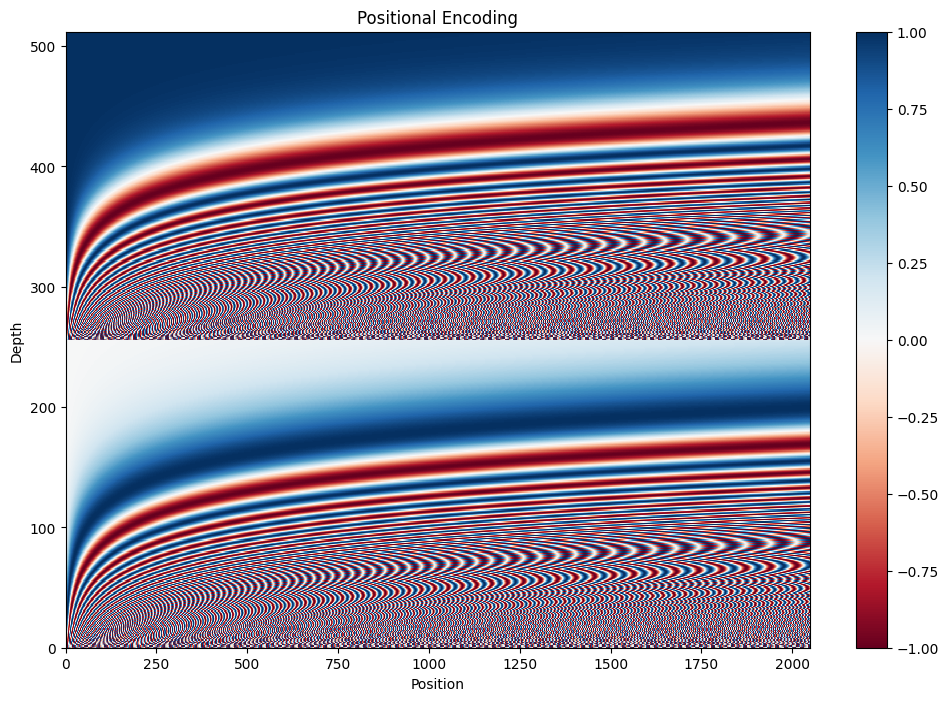

Маска для encoder inputs: (64, 128)


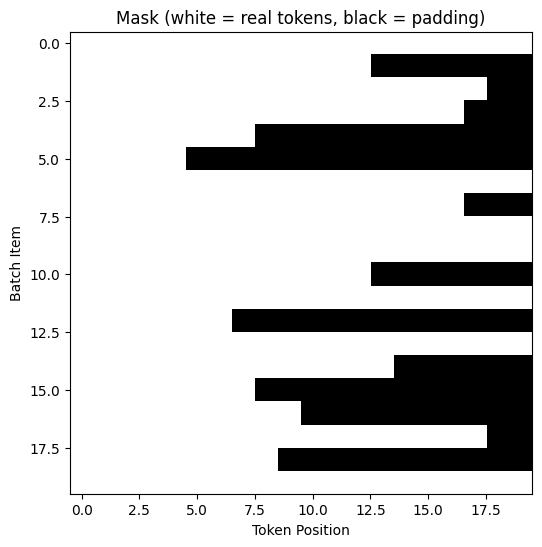

In [ ]:
embedding_layer = PositionalEmbedding(vocab_size=custom_tokenizer.get_vocab_size().numpy(), d_model=512)

# Берем пример из вашего датасета
sample_batch = next(iter(val_dataset))
(encoder_inputs, decoder_inputs), decoder_labels = sample_batch

# Применяем positional embedding к входу кодировщика
embedded_encoder = embedding_layer(encoder_inputs)

# Применяем positional embedding к входу декодера
embedded_decoder = embedding_layer(decoder_inputs)

# Проверяем результаты
print("Форма входов кодировщика:", encoder_inputs.shape)
print("Форма эмбеддингов кодировщика:", embedded_encoder.shape)
print()
print("Форма входов декодера:", decoder_inputs.shape)
print("Форма эмбеддингов декодера:", embedded_decoder.shape)

# Визуализируем эмбеддинги (опционально)
import matplotlib.pyplot as plt

# Визуализация позиционного кодирования
pos_encoding = embedding_layer.pos_encoding
plt.figure(figsize=(12, 8))
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')  # Транспонируем матрицу
plt.xlabel('Position')
plt.ylabel('Depth')
plt.colorbar()
plt.title('Positional Encoding')
plt.show()

# Визуализация масок
mask = embedding_layer.compute_mask(encoder_inputs)
print("Маска для encoder inputs:", mask.shape)

plt.figure(figsize=(10, 6))
plt.imshow(mask.numpy()[:20, :20], cmap='gray')  # Покажем первые 20x20 элементов
plt.title('Mask (white = real tokens, black = padding)')
plt.xlabel('Token Position')
plt.ylabel('Batch Item')
plt.show()

Мы видим, как работает позиционное кодирование на графиках, а так же маскирование примеров.

## Базовый класс Attention

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

## Encoder-Decoder Attention

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    # Пропускаем сигнал через многоголовое внимание
    attn_output, attn_scores = self.mha(
        query=x,                        # запрос
        key=context,                    # ключ
        value=context,                  # значение
        return_attention_scores=True)   # возвращаем оценки внимания

    # Запоминаем оценки на будущее
    self.last_attn_scores = attn_scores

    # Добавляем остаточную связь и нормализацию
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

(64, 128, 512)
(64, 128, 512)
Форма вывода CrossAttention:  (64, 128, 512)
Форма attention scores: (64, 2, 128, 128)


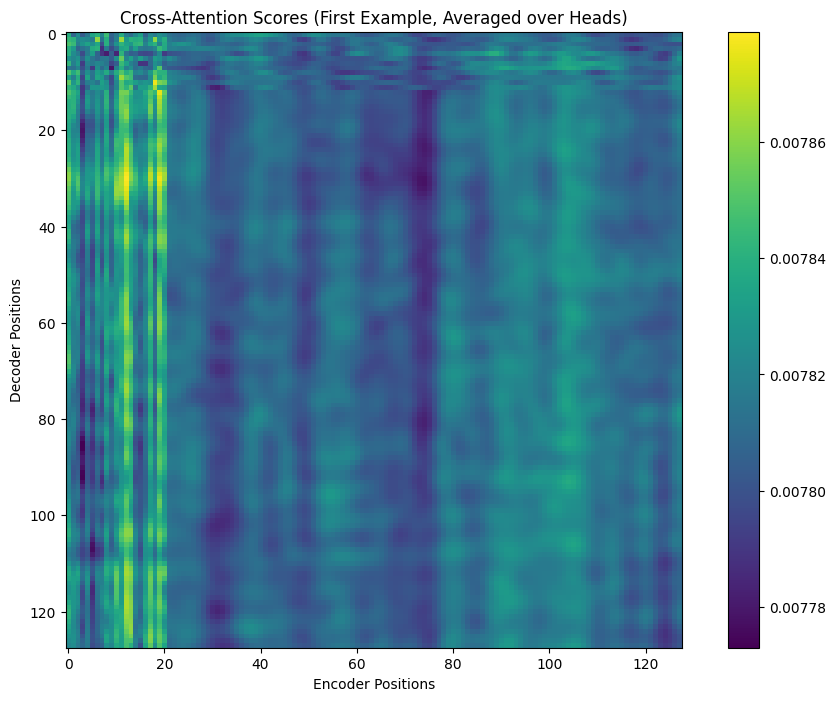

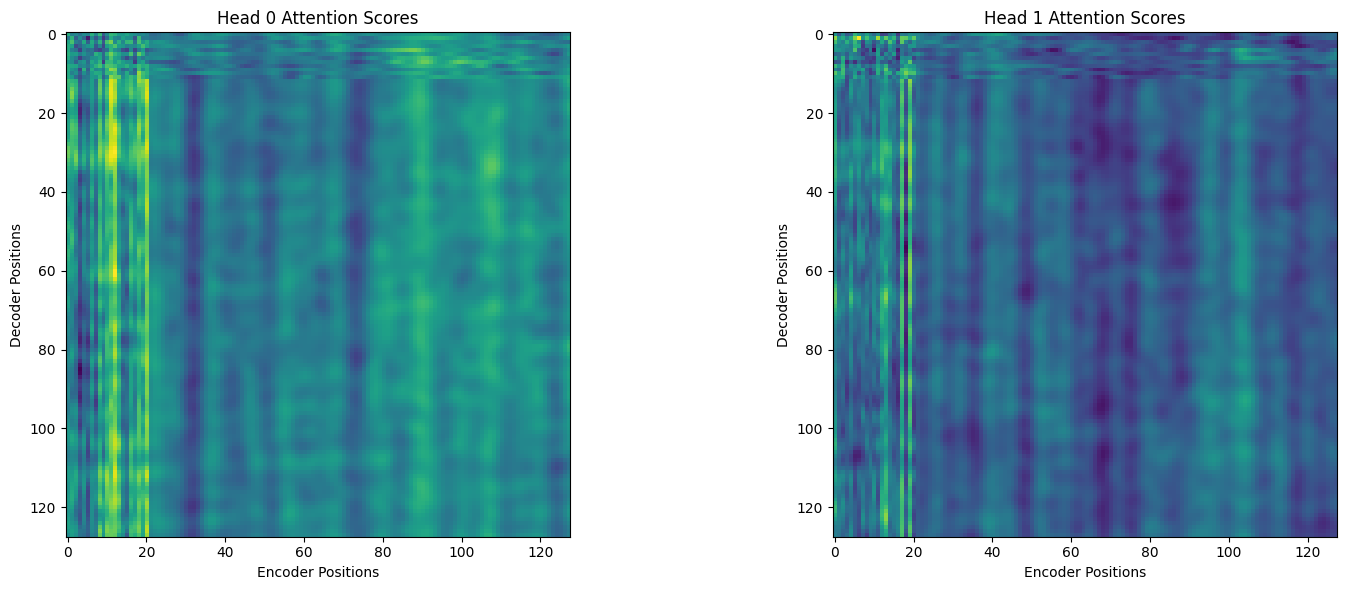

In [ ]:
# При инициализации через базовый класс передаем в слой tf.keras.layers.MultiHeadAttention
# параметры num_heads - число голов, key_dim - размерность ключа
sample_ca = CrossAttention(num_heads=2, key_dim=512)

# Проверяем формы эмбеддингов
print(embedded_encoder.shape)
print(embedded_decoder.shape)

# Проверяем форму вывода
print("Форма вывода CrossAttention: ", sample_ca(embedded_decoder, embedded_encoder).shape)
# Проверяем attention scores
print("Форма attention scores:", sample_ca.last_attn_scores.shape)

# Визуализируем attention scores для первого примера в батче
plt.figure(figsize=(12, 8))

# Усредняем по головам внимания для первого примера
avg_attention = tf.reduce_mean(sample_ca.last_attn_scores[0], axis=0)
plt.imshow(avg_attention.numpy(), cmap='viridis')
plt.xlabel('Encoder Positions')
plt.ylabel('Decoder Positions')
plt.title('Cross-Attention Scores (First Example, Averaged over Heads)')
plt.colorbar()
plt.show()

# Или визуализируем каждую голову отдельно
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i in range(2):
    axes[i].imshow(sample_ca.last_attn_scores[0][i].numpy(), cmap='viridis')
    axes[i].set_xlabel('Encoder Positions')
    axes[i].set_ylabel('Decoder Positions')
    axes[i].set_title(f'Head {i} Attention Scores')

plt.tight_layout()
plt.show()

In [ ]:
# Проверим статистику attention scores
print("Статистика attention scores:")
print("  Минимальное значение:", tf.reduce_min(sample_ca.last_attn_scores).numpy())
print("  Максимальное значение:", tf.reduce_max(sample_ca.last_attn_scores).numpy())
print("  Среднее значение:", tf.reduce_mean(sample_ca.last_attn_scores).numpy())

# Проверим, что сумма весов внимания по ключам равна 1 для каждого запроса
# (это важное свойство механизма внимания)
attention_sum = tf.reduce_sum(sample_ca.last_attn_scores, axis=-1)
print("Сумма весов внимания по ключам (должна быть близка к 1):")
print("  Минимальная сумма:", tf.reduce_min(attention_sum).numpy())
print("  Максимальная сумма:", tf.reduce_max(attention_sum).numpy())

Статистика attention scores:
  Минимальное значение: 0.007706523
  Максимальное значение: 0.007940239
  Среднее значение: 0.0078125
Сумма весов внимания по ключам (должна быть близка к 1):
  Минимальная сумма: 0.9999999
  Максимальная сумма: 1.0000001


Качество графика внимания показывает, что слой внимания работает - какие то позиции с большим вниманием, какие то с меньшим. А так же видим правильные подсчеты суммы весов, которые должны быть близки к 1.

## Global SelfAttention

In [ ]:
class vis_GlobalSelfAttention(BaseAttention):
  def call(self, x):
    # Пропускаем сигнал через многоголовое внимание
    attn_output, attn_scores = self.mha(
        query=x,  # запрос
        value=x,  # ключ
        key=x,    # значение
        return_attention_scores=True)  # возвращаем оценки внимания для визуализации

    # Запоминаем оценки на будущее
    self.last_attn_scores = attn_scores

    # Добавляем остаточную связь и нормализацию
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Форма входных данных: (64, 128, 512)
Форма выходных данных: (64, 128, 512)
Форма attention scores: (64, 2, 128, 128)


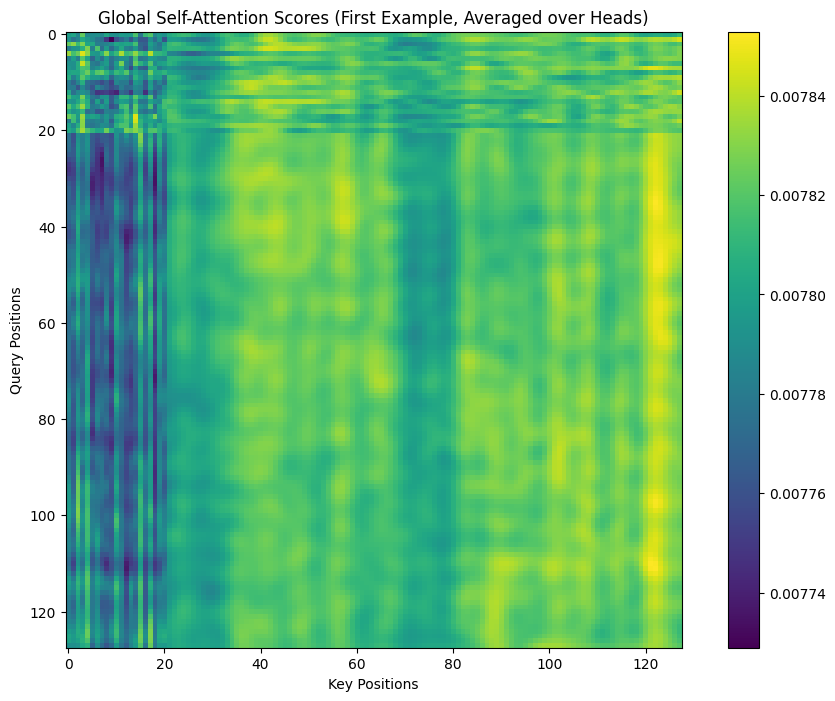

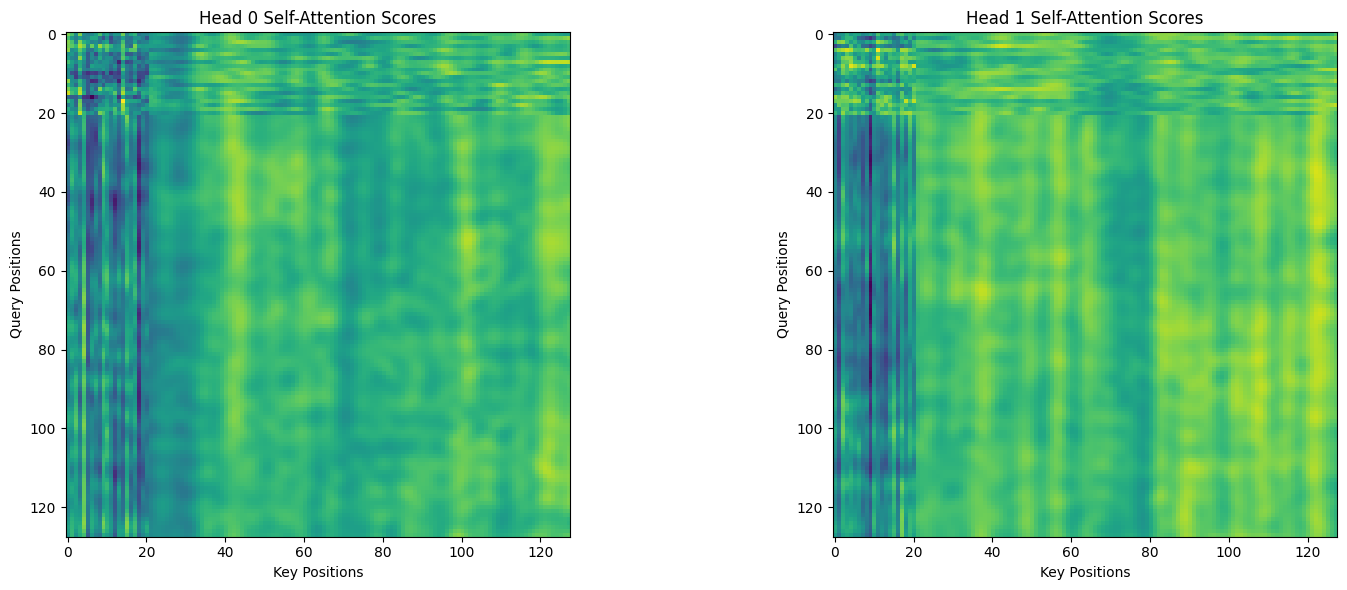

Статистика self-attention scores:
  Минимальное значение: 0.0076757427
  Максимальное значение: 0.007897879
  Среднее значение: 0.0078125
Сумма весов внимания по ключам (должна быть близка к 1):
  Минимальная сумма: 0.9999999
  Максимальная сумма: 1.0000001


In [ ]:
# Создаем экземпляр GlobalSelfAttention
sample_gsa = vis_GlobalSelfAttention(num_heads=2, key_dim=512)

# Применяем к эмбеддингам кодировщика
gsa_output = sample_gsa(embedded_encoder)

# Проверяем формы
print("Форма входных данных:", embedded_encoder.shape)
print("Форма выходных данных:", gsa_output.shape)
print("Форма attention scores:", sample_gsa.last_attn_scores.shape)

# Визуализируем attention scores для первого примера в батче
plt.figure(figsize=(12, 8))

# Усредняем по головам внимания для первого примера
avg_attention = tf.reduce_mean(sample_gsa.last_attn_scores[0], axis=0)
plt.imshow(avg_attention.numpy(), cmap='viridis')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.title('Global Self-Attention Scores (First Example, Averaged over Heads)')
plt.colorbar()
plt.show()

# Визуализируем каждую голову отдельно
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i in range(2):
    axes[i].imshow(sample_gsa.last_attn_scores[0][i].numpy(), cmap='viridis')
    axes[i].set_xlabel('Key Positions')
    axes[i].set_ylabel('Query Positions')
    axes[i].set_title(f'Head {i} Self-Attention Scores')

plt.tight_layout()
plt.show()

# Проверим статистику attention scores
print("Статистика self-attention scores:")
print("  Минимальное значение:", tf.reduce_min(sample_gsa.last_attn_scores).numpy())
print("  Максимальное значение:", tf.reduce_max(sample_gsa.last_attn_scores).numpy())
print("  Среднее значение:", tf.reduce_mean(sample_gsa.last_attn_scores).numpy())

# Проверим, что сумма весов внимания по ключам равна 1 для каждого запроса
attention_sum = tf.reduce_sum(sample_gsa.last_attn_scores, axis=-1)
print("Сумма весов внимания по ключам (должна быть близка к 1):")
print("  Минимальная сумма:", tf.reduce_min(attention_sum).numpy())
print("  Максимальная сумма:", tf.reduce_max(attention_sum).numpy())

Слой внимания так же работает корректно.

уберем возврат весов внимания из рабочего класса слоя, они были нужны для визуализации и проверки

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    # Пропускаем сигнал через многоголовое внимание
    attn_output = self.mha(
        query=x,  # запрос
        value=x,  # ключ
        key=x)    # значение

    # Добавляем остаточную связь и нормализацию
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## CausalSelfAttention слой (с причинно-следственной связью)

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    # Пропускаем сигнал через многоголовое внимание с causal mask
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask=True,
        return_attention_scores=True)  # возвращаем оценки внимания

    # Запоминаем оценки на будущее
    self.last_attn_scores = attn_scores

    # Добавляем остаточную связь и нормализацию
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Форма входных данных (декодер): (64, 128, 512)
Форма выходных данных: (64, 128, 512)
Форма attention scores: (64, 2, 128, 128)


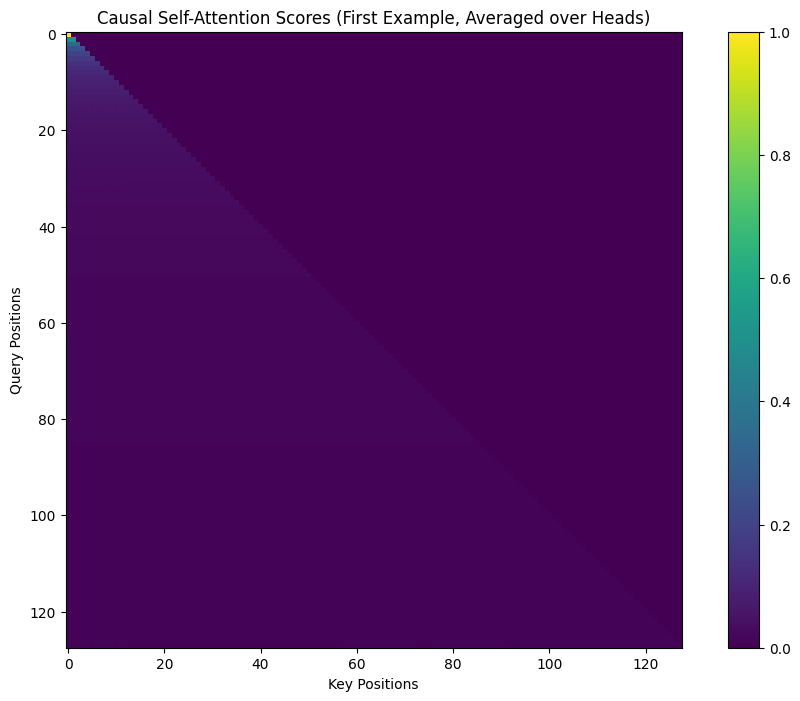

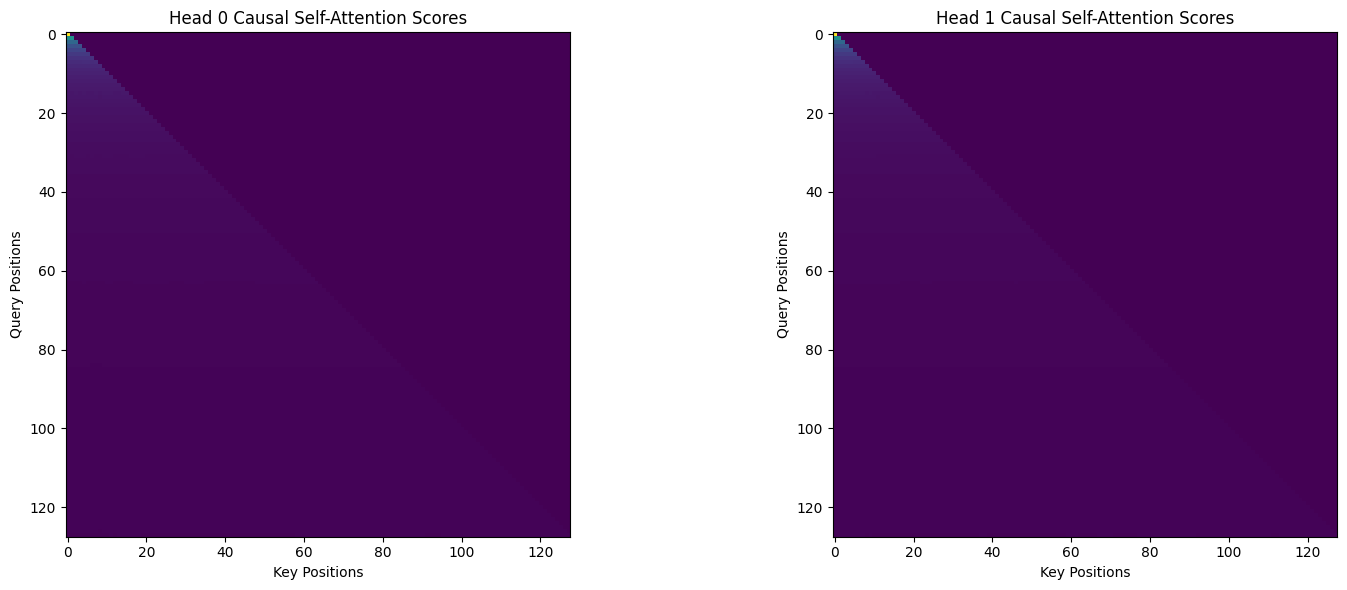

Статистика causal self-attention scores:
  Минимальное значение: 0.0
  Максимальное значение: 1.0
  Среднее значение: 0.0078125
Сумма весов внимания по ключам (должна быть близка к 1):
  Минимальная сумма: 0.9999998
  Максимальная сумма: 1.0000002
Проверка causal mask:
  Максимальное значение выше диагонали: 0.0
  Среднее значение выше диагонали: 0.0
  Максимальное значение на/ниже диагонали: 1.0
  Среднее значение на/ниже диагонали: 0.0078125


In [ ]:
# Создаем экземпляр CausalSelfAttention
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

# Применяем к эмбеддингам декодера (для декодера используется causal self-attention)
csa_output = sample_csa(embedded_decoder)

# Проверяем формы
print("Форма входных данных (декодер):", embedded_decoder.shape)
print("Форма выходных данных:", csa_output.shape)
print("Форма attention scores:", sample_csa.last_attn_scores.shape)

# Визуализируем attention scores для первого примера в батче
plt.figure(figsize=(12, 8))

# Усредняем по головам внимания для первого примера
avg_attention = tf.reduce_mean(sample_csa.last_attn_scores[0], axis=0)
plt.imshow(avg_attention.numpy(), cmap='viridis')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.title('Causal Self-Attention Scores (First Example, Averaged over Heads)')
plt.colorbar()
plt.show()

# Визуализируем каждую голову отдельно
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i in range(2):
    axes[i].imshow(sample_csa.last_attn_scores[0][i].numpy(), cmap='viridis')
    axes[i].set_xlabel('Key Positions')
    axes[i].set_ylabel('Query Positions')
    axes[i].set_title(f'Head {i} Causal Self-Attention Scores')

plt.tight_layout()
plt.show()

# Проверим статистику attention scores
print("Статистика causal self-attention scores:")
print("  Минимальное значение:", tf.reduce_min(sample_csa.last_attn_scores).numpy())
print("  Максимальное значение:", tf.reduce_max(sample_csa.last_attn_scores).numpy())
print("  Среднее значение:", tf.reduce_mean(sample_csa.last_attn_scores).numpy())

# Проверим, что сумма весов внимания по ключам равна 1 для каждого запроса
attention_sum = tf.reduce_sum(sample_csa.last_attn_scores, axis=-1)
print("Сумма весов внимания по ключам (должна быть близка к 1):")
print("  Минимальная сумма:", tf.reduce_min(attention_sum).numpy())
print("  Максимальная сумма:", tf.reduce_max(attention_sum).numpy())

# Проверим наличие causal mask (верхний треугольник должен быть близок к 0)
# Для этого посмотрим на attention scores для первого примера, первой головы
first_head_scores = sample_csa.last_attn_scores[0][0].numpy()

# Проверим, что элементы выше главной диагонали близки к 0 (заблокированы)
print("Проверка causal mask:")
upper_triangle = np.triu(first_head_scores, k=1)  # элементы выше диагонали
print("  Максимальное значение выше диагонали:", np.max(upper_triangle))
print("  Среднее значение выше диагонали:", np.mean(upper_triangle))

# Для сравнения посмотрим на элементы на и ниже диагонали
lower_triangle = np.tril(first_head_scores)  # элементы на и ниже диагонали
print("  Максимальное значение на/ниже диагонали:", np.max(lower_triangle))
print("  Среднее значение на/ниже диагонали:", np.mean(lower_triangle))

Здесь видна четкая картина треугольного распределения видимости позиций, что является корректным, т.к. модель не должна выдеть весь выход сразу, а генерировать его по шагам, чтобы точнее обрабатывать каждый последующий токен, который будет зависеть от предыдущего прохода.

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)  # отличается от GlobalSelfAttention одним аргументом
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## Сеть прямого распространения (feed forward network)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
# Создаем экземпляр FeedForward
sample_ffn = FeedForward(d_model=512, dff=2048, dropout_rate=0.1)

# Применяем к выходу одного из предыдущих слоев (например, после self-attention)
ffn_output = sample_ffn(csa_output)

# Проверяем формы
print("Форма входных данных:", csa_output.shape)
print("Форма выходных данных:", ffn_output.shape)

# Проверяем, что выход не идентичен входу (слой что-то делает)
print("Изменение после FeedForward:")
print("  Максимальное изменение:", tf.reduce_max(tf.abs(csa_output - ffn_output)).numpy())
print("  Среднее изменение:", tf.reduce_mean(tf.abs(csa_output - ffn_output)).numpy())

# Проверяем статистику выходных значений
print("Статистика выходных данных FeedForward:")
print("  Минимальное значение:", tf.reduce_min(ffn_output).numpy())
print("  Максимальное значение:", tf.reduce_max(ffn_output).numpy())
print("  Среднее значение:", tf.reduce_mean(ffn_output).numpy())
print("  Стандартное отклонение:", tf.math.reduce_std(ffn_output).numpy())

# Проверяем, что слой правильно обрабатывает разные входные данные
# Создаем тестовый вход с правильной размерностью
test_input = tf.constant([
    [1.0, 0.0, -1.0, 2.0] * 128,  # повторяем 4 значения 128 раз = 512 элементов
    [0.5, -0.5, 1.5, -2.0] * 128   # повторяем 4 значения 128 раз = 512 элементов
], dtype=tf.float32)

# Изменяем форму для соответствия ожидаемой размерности
test_input = tf.reshape(test_input, [2, 1, 512])  # форма (2, 1, 512)

# Создаем FeedForward с правильными параметрами
test_ffn = FeedForward(d_model=512, dff=2048, dropout_rate=0.0)  # используем d_model=512
test_output = test_ffn(test_input)

print("\nТест с детерминированным входом:")
print("Форма тестового входа:", test_input.shape)
print("Форма тестового выхода:", test_output.shape)
print("Изменение после FeedForward:", tf.reduce_mean(tf.abs(test_input - test_output)).numpy())

Форма входных данных: (64, 128, 512)
Форма выходных данных: (64, 128, 512)
Изменение после FeedForward:
  Максимальное изменение: 2.3703802
  Среднее изменение: 0.40730274
Статистика выходных данных FeedForward:
  Минимальное значение: -3.8846352
  Максимальное значение: 3.5651586
  Среднее значение: -1.8553692e-10
  Стандартное отклонение: 0.9996062

Тест с детерминированным входом:
Форма тестового входа: (2, 1, 512)
Форма тестового выхода: (2, 1, 512)
Изменение после FeedForward: 0.5731877


Мы видим что слой работает корректно - пропускает через себя значения и вносит изменения.

# Собираем сеть целиком

## Слой кодировщика

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,  # число голов
        key_dim=d_model,      # размерность ключа
        dropout=dropout_rate) # уровень регуляризации

    self.ffn = FeedForward(d_model, dff) # число нейронов во втором и первом Dense слое, соответственно

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(embedded_encoder.shape)
print(sample_encoder_layer(embedded_encoder).shape)

(64, 128, 512)
(64, 128, 512)


## Блок кодировщика

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    # Инициируем переменные внутри класса
    self.d_model = d_model
    self.num_layers = num_layers

    # Создаем объект класса позиционного кодирования
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    # Создаем объект класса для слоя кодировщика
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    # Создаем объект класса для слоя регуляризации
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # Форма x токена: (batch, seq_len)
    # Прогоняем последовательность токенов через слой позиционного кодирования
    x = self.pos_embedding(x)  # форма на выходе (batch_size, seq_len, d_model)

    # Прогоняем последовательность токенов через слой регуляризации
    x = self.dropout(x)

    # Прогоняем последовательность токенов через num_layers слоев кодировщика
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # форма на выходе (batch_size, seq_len, d_model)

In [ ]:
VOCAB_SIZE=custom_tokenizer.get_vocab_size().numpy()

sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=VOCAB_SIZE)

print("Форма входных данных:", encoder_inputs.shape)

# Пропускаем данные через энкодер
sample_encoder_output = sample_encoder(encoder_inputs, training=False)

print("Форма выходных данных энкодера:", sample_encoder_output.shape)

Форма входных данных: (64, 128)
Форма выходных данных энкодера: (64, 128, 512)


Размерности в необходимых позоциях корректно совпадают

## Слой декодировщика

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    # Слой внимания с причинно-следственной связью
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # Слой с кросс-вниманием
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # Слой прямого распространения
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    # Пропускаем последовательность токенов через:
    # Каузальный слой внимания
    x = self.causal_self_attention(x=x)
    # Слой кросс-внимания и контекстным вектором из кодировщика
    x = self.cross_attention(x=x, context=context)

    # Запомним оценки внимания на будущее
    self.last_attn_scores = self.cross_attention.last_attn_scores
    # Через слой прямого распространения
    x = self.ffn(x)  # Форма `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=embedded_decoder, context=embedded_encoder)

print(embedded_decoder.shape)
print(embedded_encoder.shape)
print(sample_decoder_layer_output.shape)  # Форма `(batch_size, seq_len, d_model)`

(64, 128, 512)
(64, 128, 512)
(64, 128, 512)


## Блок декодировщика

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    # Инициируем переменные внутри класса
    self.d_model = d_model
    self.num_layers = num_layers

    # Создаем объект класса позиционного кодирования
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    # Создаем объект класса для слоя регуляризации
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    # Создаем сразу стек слоев декодировщиков с помощью генератора списков по числу слоев
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    # Сбрасываем оценки внимания
    self.last_attn_scores = None

  def call(self, x, context):
    # Подаем на вход последовательность токенов x формой (batch, target_seq_len)

    # Пропускаем через слой позиционного кодирования (и конечно же эмбеддинг)
    x = self.pos_embedding(x)  # форма на выходе (batch_size, target_seq_len, d_model)

    # Регуляризация
    x = self.dropout(x)

    # Прогоняем через num_layers слоев декодировщиков
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    # Сохраняем оценки внимания из последнего слоя
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # Форма x на выходе (batch_size, target_seq_len, d_model)
    return x

In [ ]:
# Получаем размер словаря из вашего токенизатора
VOCAB_SIZE = custom_tokenizer.get_vocab_size().numpy()

# Создаем экземпляр декодера
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=VOCAB_SIZE)

# Берем пример входных данных для декодера (ответы) и выход энкодера (контекст)
print("Форма входных данных декодера (ответы):", decoder_inputs.shape)
print("Форма контекста от энкодера (вопросы):", sample_encoder_output.shape)

# Пропускаем данные через декодер
decoder_output = sample_decoder(
    x=decoder_inputs,
    context=sample_encoder_output)

print("Форма выходных данных декодера:", decoder_output.shape)

Форма входных данных декодера (ответы): (64, 128)
Форма контекста от энкодера (вопросы): (64, 128, 512)
Форма выходных данных декодера: (64, 128, 512)


In [ ]:
sample_decoder.last_attn_scores.shape # форма оценок внимания на выходе из декодировщика (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 128, 128])

Проверили слои по размерностям, все в порядке - моджем собирать наш трансформер.

# Трансформер

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               vocab_size, dropout_rate=0.1):
    super().__init__()
    # Кодировщик
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=vocab_size,
                           dropout_rate=dropout_rate)
    # Декодировщик
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=vocab_size,
                           dropout_rate=dropout_rate)
    # Конечный слой
    self.final_layer = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs):
    # Чтобы использовать метод `.fit` для обучения модели, необходимо передать
    # все входные данные в первом аргументе
    context, x  = inputs

    # Передаем контекст в кодировщик
    context = self.encoder(context)  # форма выходных данных (batch_size, context_len, d_model)

    # Передаем контекст и целевой вектор в декодировщик
    x = self.decoder(x, context)  # форма выходных данных (batch_size, target_len, d_model)

    # Прогоняем выходные данные через финальный слой
    logits = self.final_layer(x)  # форма выходных данных (batch_size, target_len, target_vocab_size)

    try:
      # После прохождения данных через все слои необходимо удалить
      # маску, чтобы она не масштабировала потери и метрики
      # Обработчик ошибок позволяет избежать исключений при повторной попытке удаления
      del logits._keras_mask
    except AttributeError: # отлавливаем ошибку отсутствия аттрибута
      pass

    # Возвращаем наши логиты
    return logits

# Обучение

Соберем трансформер с заданными параметрами:

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1


EPOCHS = 5

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    vocab_size=VOCAB_SIZE,
    dropout_rate=dropout_rate)

In [ ]:
# Берем пример входных данных
# context = вопросы (вход энкодера)
# x = ответы (вход декодера)
context_input = encoder_inputs[:1]  # берем первый пример из батча
x_input = decoder_inputs[:1]        # берем первый пример из батча

print("Форма входных данных энкодера (вопросы):", context_input.shape)
print("Форма входных данных декодера (ответы):", x_input.shape)

# Пропускаем данные через трансформер
output = transformer((context_input, x_input), training=False)

print("Форма выходных данных трансформера:", output.shape)

# Проверяем, что выход имеет правильную форму
assert output.shape[0] == context_input.shape[0], "Размер батча должен сохраняться"
assert output.shape[1] == x_input.shape[1], "Длина последовательности должна сохраняться"
assert output.shape[2] == VOCAB_SIZE, "Последняя размерность должна быть равна размеру словаря"

print("✓ Форма выходных данных корректна")

# Проверяем статистику выходных данных (логитов)
print("Статистика выходных логитов:")
print("  Минимальное значение:", tf.reduce_min(output).numpy())
print("  Максимальное значение:", tf.reduce_max(output).numpy())
print("  Среднее значение:", tf.reduce_mean(output).numpy())
print("  Стандартное отклонение:", tf.math.reduce_std(output).numpy())

# Проверяем, что выходные данные отличаются от входных
print("Максимальное изменение после трансформера:", tf.reduce_max(tf.abs(output)).numpy())

# Проверяем, что можем получить предсказания (индексы токенов)
predictions = tf.argmax(output, axis=-1)
print("Форма предсказаний:", predictions.shape)
print("Пример предсказаний для первого токена:", predictions[0, :10].numpy())

# Проверяем работу в режиме обучения
output_training = transformer((context_input, x_input), training=True)
output_inference = transformer((context_input, x_input), training=False)

diff = tf.reduce_mean(tf.abs(output_training - output_inference))
print("Разница между режимами обучения и инференса:", diff.numpy())

Форма входных данных энкодера (вопросы): (1, 128)
Форма входных данных декодера (ответы): (1, 128)
Форма выходных данных трансформера: (1, 128, 12000)
✓ Форма выходных данных корректна
Статистика выходных логитов:
  Минимальное значение: -0.67428154
  Максимальное значение: 0.6834591
  Среднее значение: -0.002636131
  Стандартное отклонение: 0.14502996
Максимальное изменение после трансформера: 0.6834591
Форма предсказаний: (1, 128)
Пример предсказаний для первого токена: [  315 11708   315 10926  7375  7375  4158  4158  4158  7375]
Разница между режимами обучения и инференса: 0.05117908


Проверка, что градиенты могут протекать через всю модель

In [ ]:
with tf.GradientTape() as tape:
    output = transformer((context_input, x_input), training=False)
    loss = tf.reduce_mean(output**2)

# Получаем обучаемые параметры модели
trainable_vars = transformer.trainable_variables
gradients = tape.gradient(loss, trainable_vars)

# Проверяем, что градиенты не None и не нулевые
non_zero_gradients = [g for g in gradients if g is not None and tf.reduce_max(tf.abs(g)) > 0]
print("Количество не-zero градиентов:", len(non_zero_gradients))
print("Общее количество параметров:", len(trainable_vars))
print("Процент параметров с не-zero градиентами:", len(non_zero_gradients) / len(trainable_vars) * 100)

Количество не-zero градиентов: 172
Общее количество параметров: 172
Процент параметров с не-zero градиентами: 100.0


Визуализация архитектуры модели:

In [ ]:
# Выведем ключевую информацию о модели вручную
print("=== ИНФОРМАЦИЯ О МОДЕЛИ ТРАНСФОРМЕРА ===")
print(f"Количество слоев: {num_layers}")
print(f"Размерность модели (d_model): {d_model}")
print(f"Размерность FFN (dff): {dff}")
print(f"Количество голов внимания: {num_heads}")
print(f"Размер словаря: {VOCAB_SIZE}")
print(f"Dropout rate: {dropout_rate}")

# Оценим примерное количество параметров
approx_params = (
    VOCAB_SIZE * d_model +  # word embeddings
    num_layers * (4 * d_model * d_model + 4 * d_model * dff) +  # encoder layers
    num_layers * (4 * d_model * d_model + 4 * d_model * dff) +  # decoder layers
    d_model * VOCAB_SIZE  # final dense layer
)
print(f"Примерное количество параметров: {approx_params:,}")

=== ИНФОРМАЦИЯ О МОДЕЛИ ТРАНСФОРМЕРА ===
Количество слоев: 4
Размерность модели (d_model): 128
Размерность FFN (dff): 512
Количество голов внимания: 8
Размер словаря: 11969
Dropout rate: 0.1
Примерное количество параметров: 5,685,504


## Расписание обучения

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
# Количество батчей для обучения
num_batches = 0
for (batch, (_,_)) in enumerate(train_dataset):
  num_batches = batch
print(num_batches)

17279


In [ ]:
# чтобы не пересчитывать
num_batches = 17279

Text(0.5, 0, 'Шаг обучения')

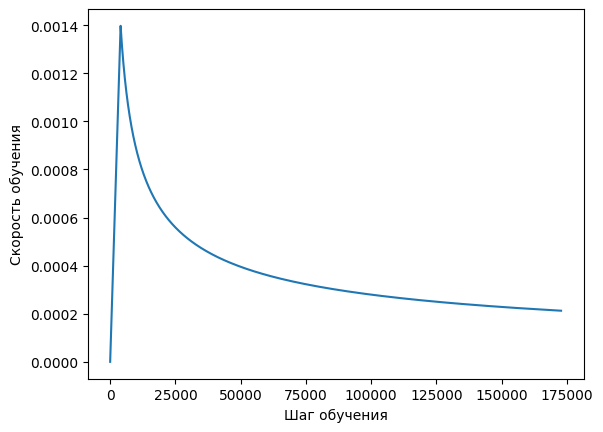

In [ ]:
plt.plot(learning_rate(tf.range(num_batches*EPOCHS*2, dtype=tf.float32)))
plt.ylabel('Скорость обучения')
plt.xlabel('Шаг обучения')

## Функция потерь

In [ ]:
# Функция потерь с учетом маски
def masked_loss(label, pred):
  # Задаем маску, где метки не равны 0
  mask = label != 0
  # Определяем функцию потерь
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  # Важно чтобы mask и loss имели одинаковый тип данных
  mask = tf.cast(mask, dtype=loss.dtype)
  # Наложение маски на loss
  loss *= mask

  # Масштабирование потерь на маску
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

# Функция точности с учетом маски
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  # Оценка совпадения метки и предсказания
  match = label == pred
  # Задаем маску, где метки не равны 0
  mask = label != 0

  # Логическое И
  match = match & mask

  # Преобразуем к одному типу и масштабирование совпадений на маску
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Компиляция и обучение

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.build(input_shape=[(None, MAX_TOKENS), (None, MAX_TOKENS)])

In [ ]:
class Chat_Model(tf.Module):
  def __init__(self, tokenizer, transformer):
    self.tokenizer = tokenizer  # Используем один токенизатор вместо двух
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    assert isinstance(sentence, tf.Tensor)  # Проверяем, что последовательность является тензором

    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    # Токенизируем входное предложение
    sentence = self.tokenizer.tokenize(sentence).to_tensor()
    encoder_input = sentence

    # Получаем индексы START и END токенов из зарезервированных токенов
    start_token_idx = tf.argmax(tf.constant(reserved_tokens) == "[START]")
    end_token_idx = tf.argmax(tf.constant(reserved_tokens) == "[END]")

    # Инициализируем вывод с помощью токена [START]
    start = tf.fill([1, 1], start_token_idx)

    # Используем tf.TensorArray для динамического цикла
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start[0])  # Записываем START токен

    for i in tf.range(max_length):
        # На каждом шаге собираем выходные токены для передачи на вход на следующем шаге
        output = tf.transpose(output_array.stack())

        # Передаем в трансформер для предсказания
        predictions = self.transformer([encoder_input, output], training=False)

        # Выбираем последний токен из измерения `seq_len`
        predictions = predictions[:, -1:, :]  # Форма `(batch_size, 1, vocab_size)`.

        # Предсказанный токен
        predicted_id = tf.argmax(predictions, axis=-1)

        # Объединяем `predicted_id` с выходными данными
        output_array = output_array.write(i+1, predicted_id[0])

        # Если предсказан токен конца, выходим из цикла
        if predicted_id == end_token_idx:
            break

    output = tf.transpose(output_array.stack())

    # Преобразуем токены в текст
    text = self.tokenizer.detokenize(output)[0]  # Shape: `()`.

    # Получаем текстовое представление токенов
    tokens = self.tokenizer.lookup(output)[0]

    # Пересчитываем веса внимания вне цикла
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
example_question = relevant_split['test']['question'][0]  # Первый пример
print(example_question)

какое вещество, образуемое из серной кислоты, можно купить в аптеке?


In [ ]:
chat = Chat_Model(custom_tokenizer, transformer)

In [ ]:
sentence = tf.constant(example_question)
text, tokens, attention_weights = chat(sentence)

print("Ответ:", text.numpy().decode('utf-8'))

Ответ: отнести покупаете покупаетепускаетпускаетпускаетечнуюечную борьбыговорите грязьизировать извините просмотра извините извините извините христос извините порядочность слышала извините порядочностьсатьтнее птицшили извините комфорта мужики вены вены извините ждет извините ждет близко работает зарабатывают часадываю спасение вредноовки извинитежаешь трубы извините настоящееляются соседи отнести близко общались вены воображение отличаютсярюгла трубы военнои задать обезьянэт отнести какимрода птиц будильниклить какимцом какимицеродалить делаетсягла половогоицуицуицудаи птицживают спасениеживают спасение веныживаютживают спасениеживают соседи иллюзия сложная будильникечную сириилить музыкои личные хчныживаютбежит слабостьжаешьдываюдываюдываюd редкость статьи редкость статьиитяжаларочкирочкирник какимзе истина попить уиду почаще уиду


Продолжаем обучение

In [ ]:
history2 = transformer.fit(train_dataset,
                epochs=EPOCHS,
                validation_data=val_dataset)

Epoch 1/5
17280/17280 ━━━━━━━━━━━━━━━━━━━━ 4573s 265ms/step - loss: 5.7282 - masked_accuracy: 0.1412 - val_loss: 5.0516 - val_masked_accuracy: 0.1834
Epoch 2/5
17280/17280 ━━━━━━━━━━━━━━━━━━━━ 4485s 260ms/step - loss: 5.0003 - masked_accuracy: 0.1884 - val_loss: 4.9104 - val_masked_accuracy: 0.1971
Epoch 3/5
17280/17280 ━━━━━━━━━━━━━━━━━━━━ 4479s 259ms/step - loss: 4.8694 - masked_accuracy: 0.2007 - val_loss: 4.8351 - val_masked_accuracy: 0.2037
Epoch 4/5
17280/17280 ━━━━━━━━━━━━━━━━━━━━ 4479s 259ms/step - loss: 4.7949 - masked_accuracy: 0.2078 - val_loss: 4.7934 - val_masked_accuracy: 0.2088
Epoch 5/5
17280/17280 ━━━━━━━━━━━━━━━━━━━━ 4477s 259ms/step - loss: 4.7488 - masked_accuracy: 0.2126 - val_loss: 4.7549 - val_masked_accuracy: 0.2121


In [ ]:
chat = Chat_Model(custom_tokenizer, transformer)
sentence = tf.constant(example_question)
text, tokens, attention_weights = chat(sentence)

print("Ответ:", text.numpy().decode('utf-8'))

Ответ: можно , но не надо . а то можно и не надо .


Интересный ответ получился. продолжим обучение еще на 5 эпохах

In [ ]:
history10 = transformer.fit(train_dataset,
                epochs=10,
                initial_epoch=5,
                validation_data=val_dataset)

Epoch 6/10
17280/17280 ━━━━━━━━━━━━━━━━━━━━ 4477s 259ms/step - loss: 4.7078 - masked_accuracy: 0.2164 - val_loss: 4.7423 - val_masked_accuracy: 0.2135
Epoch 7/10
17280/17280 ━━━━━━━━━━━━━━━━━━━━ 4487s 260ms/step - loss: 4.6806 - masked_accuracy: 0.2194 - val_loss: 4.7198 - val_masked_accuracy: 0.2159
Epoch 8/10
17280/17280 ━━━━━━━━━━━━━━━━━━━━ 4490s 260ms/step - loss: 4.6605 - masked_accuracy: 0.2217 - val_loss: 4.7059 - val_masked_accuracy: 0.2175
Epoch 9/10
17280/17280 ━━━━━━━━━━━━━━━━━━━━ 4501s 260ms/step - loss: 4.6413 - masked_accuracy: 0.2240 - val_loss: 4.6948 - val_masked_accuracy: 0.2190
Epoch 10/10
17280/17280 ━━━━━━━━━━━━━━━━━━━━ 4498s 260ms/step - loss: 4.6246 - masked_accuracy: 0.2257 - val_loss: 4.6844 - val_masked_accuracy: 0.2200


In [ ]:
example_question = relevant_split['test']['question'][0]  # Первый пример
print(example_question)

In [ ]:
chat = Chat_Model(custom_tokenizer, transformer)
sentence = tf.constant(example_question)
text, tokens, attention_weights = chat(sentence)

print("Ответ:", text.numpy().decode('utf-8'))

Ответ: можно , но не нужно . если не будет , то можно и не пить .


In [ ]:
example_question = relevant_split['test']['question'][10]  # Первый пример
print(example_question)

смогли бы вы сейчас обходиться без мобильного телефона?


In [ ]:
sentence = tf.constant(example_question)
text, tokens, attention_weights = chat(sentence)

print("Ответ:", text.numpy().decode('utf-8'))

Ответ: я не знаю , но я могу и без него не обоитись .


Чтож вполне приемлемый результат для такого небольшого количества эпох.

In [ ]:
transformer.save_weights('transformer_10e.weights.h5')

# Итог

Мы загрузили датасет, обучили токенизатор на базе BERT и подготовили наш класс токенизации с добавлением и очисткой служебных токенов.

Так как датасет является достаточно большим, а обработка текста на лету происходит медленно из за функций токенизатора вне обертки `@tf.function` а так же из за пересчетов графов, то я предварительно обработал датасет и кешировал его на диск. После кеширования обработанный датасет в виде токенов подтягивается в модель. Это дало ускорение обучения с 18 s/step до 230 ms/step, и вместо 85 часов на обучение 5 эпох уходит 4.

Далее собрал пошагово слои для модели с визуализацией и проверкой их работы. Сама модель обучается на динамичном learning rate.

Перед началом обучения собрал класс для инференса и посмотрел, что модель выдает изначально на инициализированных весах.

После 5 эпох обучения снова провел инференс - модель уже стала генерировать что то осмысленное вместо набора токенов.

Продолжил обучение еще на 5 эпох. Здесь важно именно продолжить обучение с помощью
```
epochs=10 # указываем количество эпох в сумме
initial_epoch=5 # начальная эпоха этапа = конечная предыдущего
```
иначе сбросятся оптимизатор и шедулер.

После 10 эпох модель уже способна выдавать подходящие по смыслу фразы на вопросы.

Для моделей, где результат генерации не является явно определенным в обучении, т.е. модель омжет подбирать синонимы и результат будет иметь смысл, метрики точности могут служить только приблизительным ориентиром, помимо маскированной точности могут применяться и другие:

- BLEU: Сравнивает n-граммы предсказания с эталоном.

- ROUGE: Часто используется для суммаризации, но подходит и для чатов. Смотрит на пересечение слов и n-грамм.

- METEOR: Учитывает синонимы и основы слов.

- BERTScore: Оценивает семантическое сходство с помощью контекстуальных эмбеддингов BERT.

Самым важным все равно остается наблюдение за инференсом в процессе обучения, как мы проверяли между этапами обучения. Что заметно - даже при лосс 4.6 и маскированной точности 22% на валидации модель уже дает осмысленные ответы.